In [2]:
from models.detector import Detector,SetCriterion,PostProcess
import torch
import torch.nn as nn
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from datasets.coco import build, CocoDetection
from pathlib import Path
import cv2
from PIL import Image
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
from util.misc import nested_tensor_from_tensor_list
import skimage
import colorsys
import random
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from skimage import io
import datasets.transforms as T
import copy
import glob
import re

from models.matcher import HungarianMatcher
import util.misc as utils
from engine import evaluate
from datasets import get_coco_api_from_dataset

### Load Dataset

In [3]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
DET_TOKEN_NUM=100
COCO_PARH = '../coco2017/'
OUTPUT_DIR = './temp/'

In [4]:
def make_coco_transforms(image_set):
    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    scales = [800]

    if image_set == 'val' or image_set == 'train':
        return T.Compose([
            T.RandomResize([scales[-1]], max_size=scales[-1] * 1333 // 800),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')


In [5]:
def plot_gt(im, labels, bboxes_scaled, output_dir):
    tl = 3
    tf = max(tl-1, 1)
    tempimg = copy.deepcopy(im)
    color = [255,0,0]
    for label, (xmin, ymin, xmax, ymax) in zip(labels.tolist(), bboxes_scaled.tolist()):
        c1, c2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        cv2.rectangle(tempimg, c1, c2, color, tl, cv2.LINE_AA)
        text = f'{CLASSES[label]}'
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(tempimg, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(tempimg, text, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    fname = os.path.join(output_dir,'gt_img.png')
    cv2.imwrite(fname, tempimg)
    print(f"{fname} saved.")
    return tempimg

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
def draw_bbox_in_img(fname, bbox_scaled, score, color=[0,255,0]):
    tl = 3
    tf = max(tl-1,1) # font thickness
    # color = [0,255,0]
    im = cv2.imread(fname)
    for p, (xmin, ymin, xmax, ymax) in zip(score, bbox_scaled.tolist()):
        c1, c2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        cv2.rectangle(im, c1, c2, color, tl, cv2.LINE_AA)
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, text, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    cv2.imwrite(fname, im)

def plot_results(cv2_img, prob, boxes, output_dir):
    tl = 3 # thickness line
    tf = max(tl-1,1) # font thickness
    tempimg = copy.deepcopy(cv2_img)
    color = [0,0,255]
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        c1, c2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        cv2.rectangle(tempimg, c1, c2, color, tl, cv2.LINE_AA)
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(tempimg, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(tempimg, text, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    fname = os.path.join(output_dir,'pred_img.png')
    cv2.imwrite(fname, tempimg)
    print(f"{fname} saved.")
    return tempimg
    
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        suffix = path.suffix
        path = path.with_suffix('')
        dirs = glob.glob(f"{path}{sep}*")  # similar paths
        matches = [re.search(rf"%s{sep}(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]  # indices
        n = max(i) + 1 if i else 2  # increment number
        path = Path(f"{path}{sep}{n}{suffix}")  # update path
    dir = path if path.suffix == '' else path.parent  # directory
    if not dir.exists() and mkdir:
        dir.mkdir(parents=True, exist_ok=True)  # make directory
    return path

def save_pred_fig(output_dir, output_dic, keep):
    # im = Image.open(os.path.join(output_dir, "img.png"))
    im = cv2.imread(os.path.join(output_dir, "img.png"))
    h, w = im.shape[:2]
    bboxes_scaled = rescale_bboxes(output_dic['pred_boxes'][0, keep].cpu(), (w,h))
    prob = output_dic['pred_logits'].softmax(-1)[0, :, :-1]
    scores = prob[keep]
    src = plot_results(im, scores, bboxes_scaled, output_dir)
    return src

def save_gt_fig(output_dir, gt_anno):
    im = cv2.imread(os.path.join(output_dir, "img.png"))
    h, w = im.shape[:2]
    bboxes_scaled = rescale_bboxes(gt_anno['boxes'], (w,h))
    labels = gt_anno['labels']
    src = plot_gt(im, labels, bboxes_scaled, output_dir)
    return src

In [6]:
root = Path(COCO_PARH)
assert root.exists(), f'provided COCO path {root} does not exist'
mode = 'instances'
image_set='train'
PATHS = {
    "train": (root / "images/train2017", root / "annotations" / f'{mode}_train2017.json'),
    "val": (root / "images/val2017", root / "annotations" / f'{mode}_val2017.json'),
}
img_folder, ann_file = PATHS[image_set]
dataset = CocoDetection(img_folder, ann_file, transforms=make_coco_transforms(image_set), return_masks=False)
img_data, img_anno = dataset.__getitem__(0)

loading annotations into memory...
Done (t=13.19s)
creating index...
index created!


./temp/gt_img.png saved.


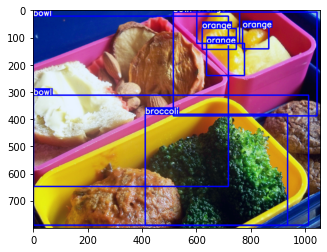

In [7]:
ret=nested_tensor_from_tensor_list(img_data.unsqueeze(0))

# save original image
os.makedirs(OUTPUT_DIR, exist_ok=True)
img = ret.tensors.squeeze(0).cpu()
torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), 
                os.path.join(OUTPUT_DIR, "img.png"))
# save GT image
src = save_gt_fig(OUTPUT_DIR, img_anno)
src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
plt.imshow(src)
plt.show()

### Load Model

In [8]:
pre_trained = 'deit_s_width_200.pth'
backbone_name = 'small'
init_pe_size = [512,864]
mid_pe_size = [512,864]

In [9]:

model = Detector(
    num_classes=91,
    pre_trained=pre_trained,
    det_token_num=DET_TOKEN_NUM,
    backbone_name=backbone_name,
    init_pe_size=init_pe_size,
    mid_pe_size=mid_pe_size,
    use_checkpoint=False,
)

device = torch.device("cuda:1")
# device = torch.device("cpu")
model.to(device)

Has mid pe


Detector(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((384,)

In [10]:
x = torch.randn((1,3,200,400)).to(device)
y = model(x)
y
del x,y

### Train

In [10]:
batch_size=1
sampler_train = torch.utils.data.RandomSampler(dataset)
batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, batch_size, drop_last=True)

data_loader = DataLoader(dataset, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, 
                                   num_workers=2)

In [11]:
matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
weight_dict = {'loss_ce': 1, 'loss_bbox': 0.1}
weight_dict['loss_giou'] = 2
losses = ['labels', 'boxes', 'cardinality']

criterion = SetCriterion(91, matcher=matcher, weight_dict=weight_dict,
                             eos_coef=0.1, losses=losses).to(device)

In [12]:
model.train()
criterion.train()

for images, targets in data_loader:
    pred = model(images.to(device))
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = criterion(pred,targets)
    print(loss_dict)
    break

{'loss_ce': tensor(4.5251, device='cuda:1', grad_fn=<NllLoss2DBackward>), 'class_error': tensor(100., device='cuda:1'), 'loss_bbox': tensor(1.1654, device='cuda:1', grad_fn=<DivBackward0>), 'loss_giou': tensor(1.0538, device='cuda:1', grad_fn=<DivBackward0>), 'cardinality_error': tensor(87., device='cuda:1')}


### Evaluation

In [11]:
resume='yolos_s_200_pre.pth'
checkpoint = torch.load(resume, map_location=device)
model.load_state_dict(checkpoint['model'])
model = model.eval()

In [14]:
image_set = 'val'
dataset_val = CocoDetection(img_folder, ann_file, transforms=make_coco_transforms(image_set), return_masks=False)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
data_loader_val = DataLoader(dataset_val, 4, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=4)
postprocessors = {'bbox': PostProcess()}

base_ds = get_coco_api_from_dataset(dataset_val)


loading annotations into memory...
Done (t=13.52s)
creating index...
index created!


In [15]:
test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,
                                              data_loader_val, base_ds, device, None)

In [ ]:
test_stats

Test:  [    0/29572]  eta: 8:54:19  class_error: 15.38  loss: 0.7696 (0.7696)  loss_ce: 0.0944 (0.0944)  loss_bbox: 0.0095 (0.0095)  loss_giou: 0.6657 (0.6657)  loss_ce_unscaled: 0.0944 (0.0944)  class_error_unscaled: 15.3846 (15.3846)  loss_bbox_unscaled: 0.0951 (0.0951)  loss_giou_unscaled: 0.3328 (0.3328)  cardinality_error_unscaled: 0.7500 (0.7500)  time: 1.0841  data: 0.7345  max mem: 0


### Prediction

./temp/pred_img.png saved.


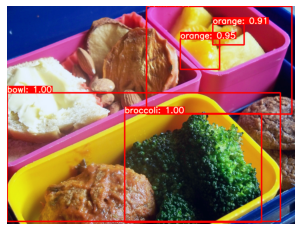

In [12]:
#forward input to get pred
result_dic = model(ret.to(device))

# get visualize dettoken index
probas = result_dic['pred_logits'].softmax(-1)[0, :, :-1].cpu()
keep = probas.max(-1).values > 0.9

# save pred image
src = save_pred_fig(OUTPUT_DIR, result_dic, keep)
src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
plt.imshow(src)
plt.axis('off')
plt.show()

### Visualize Attention

In [13]:
def get_one_query_meanattn(vis_attn,h_featmap,w_featmap):
    mean_attentions = vis_attn.mean(0).reshape(h_featmap, w_featmap)
    mean_attentions = nn.functional.interpolate(mean_attentions.unsqueeze(0).unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()
    return mean_attentions

def get_one_query_attn(vis_attn, h_featmap, w_featmap, nh):
    attentions = vis_attn.reshape(nh, h_featmap, w_featmap)
    # attentions = vis_attn.sum(0).reshape(h_featmap, w_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()
    return attentions

In [16]:
attention = model.forward_return_attention(ret.to(device))
attention = attention[-1].detach().cpu()
nh = attention.shape[1] # number of head
attention = attention[0, :, -DET_TOKEN_NUM:, 1:-DET_TOKEN_NUM]

#forward input to get pred
result_dic = model(ret.to(device))
# get visualize dettoken index
probas = result_dic['pred_logits'].softmax(-1)[0, :, :-1].cpu()
keep = probas.max(-1).values > 0.9
vis_indexs = torch.nonzero(keep).squeeze(1)

# save token image
h, w = ret.tensors.shape[2:]
w_featmap = ret.tensors.shape[3] // 16 # patch size
h_featmap = ret.tensors.shape[2] // 16 # patch size
for vis_index in vis_indexs:
    token_dir = os.path.join(OUTPUT_DIR, 'Det-Tok-'+str(int(vis_index)))
    os.makedirs(token_dir, exist_ok=True)
    # get corresponding bbox
    bbox_scaled = rescale_bboxes(result_dic['pred_boxes'][0, vis_index].unsqueeze(0).cpu(), (w,h))
    prob = result_dic['pred_logits'].softmax(-1)[0, :, :-1].cpu()
    score = prob[vis_index].unsqueeze(0)



    vis_attn = attention[:, vis_index, :]
    mean_attention = get_one_query_meanattn(vis_attn, h_featmap, w_featmap)
    mean_attention = mean_attention[0]
    fname = os.path.join(token_dir, "attn-head-mean" + ".png")
    plt.imsave(fname=fname, arr=mean_attention, format='png')
    print(f"{fname} saved.")
    attn = get_one_query_attn(vis_attn, h_featmap, w_featmap,nh)
    for j in range(nh):
        fname = os.path.join(token_dir, "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attn[j], format='png')
        draw_bbox_in_img(fname, bbox_scaled, score, color=[0,0,255])
        print(f"{fname} saved.")


./temp/Det-Tok-13/attn-head-mean.png saved.
./temp/Det-Tok-13/attn-head0.png saved.
./temp/Det-Tok-13/attn-head1.png saved.
./temp/Det-Tok-13/attn-head2.png saved.
./temp/Det-Tok-13/attn-head3.png saved.
./temp/Det-Tok-13/attn-head4.png saved.
./temp/Det-Tok-13/attn-head5.png saved.
./temp/Det-Tok-61/attn-head-mean.png saved.
./temp/Det-Tok-61/attn-head0.png saved.
./temp/Det-Tok-61/attn-head1.png saved.
./temp/Det-Tok-61/attn-head2.png saved.
./temp/Det-Tok-61/attn-head3.png saved.
./temp/Det-Tok-61/attn-head4.png saved.
./temp/Det-Tok-61/attn-head5.png saved.
./temp/Det-Tok-70/attn-head-mean.png saved.
./temp/Det-Tok-70/attn-head0.png saved.
./temp/Det-Tok-70/attn-head1.png saved.
./temp/Det-Tok-70/attn-head2.png saved.
./temp/Det-Tok-70/attn-head3.png saved.
./temp/Det-Tok-70/attn-head4.png saved.
./temp/Det-Tok-70/attn-head5.png saved.
./temp/Det-Tok-86/attn-head-mean.png saved.
./temp/Det-Tok-86/attn-head0.png saved.
./temp/Det-Tok-86/attn-head1.png saved.
./temp/Det-Tok-86/attn-h

In [17]:
path = os.listdir(OUTPUT_DIR)
det_tok_dirs=[]
for p in path:
    temp_path=os.path.join(OUTPUT_DIR,p)
    if os.path.isdir(temp_path):
        det_tok_dirs.append(temp_path)

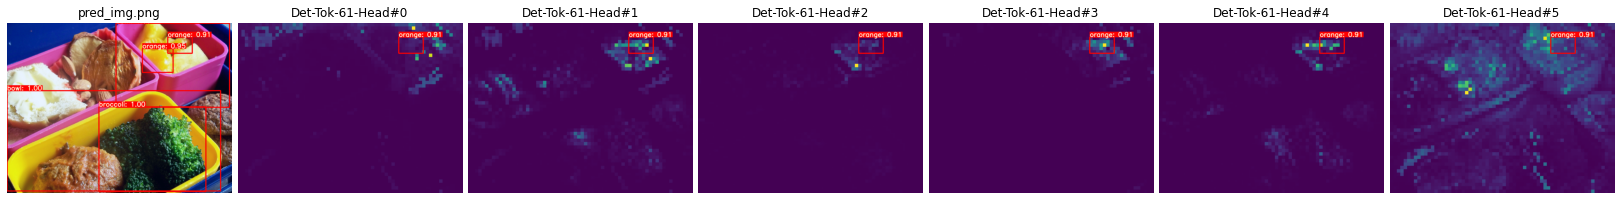

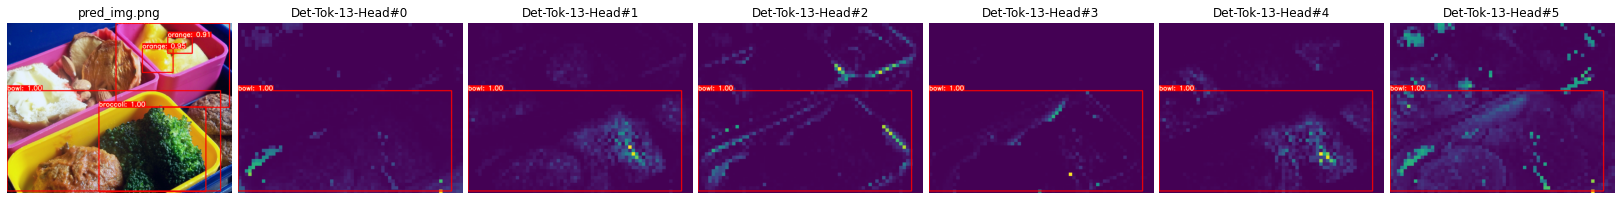

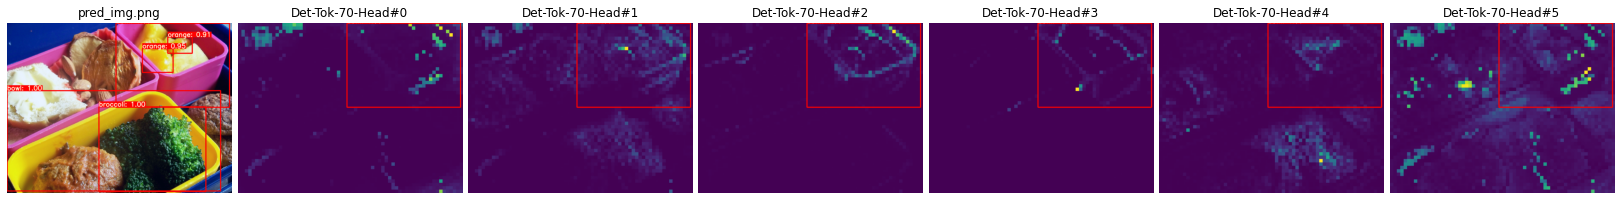

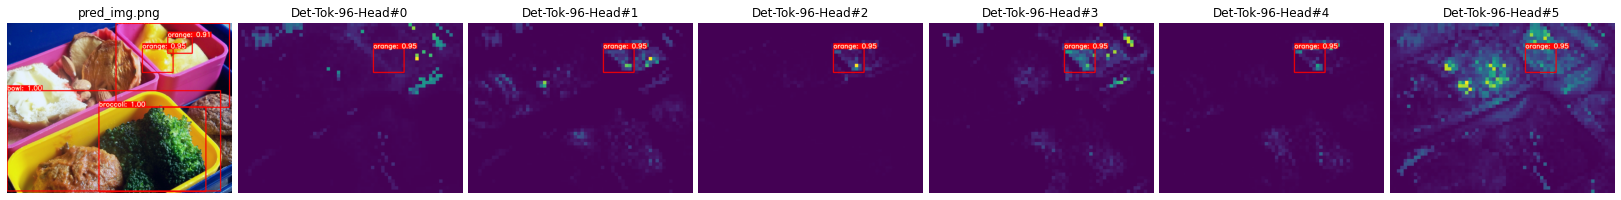

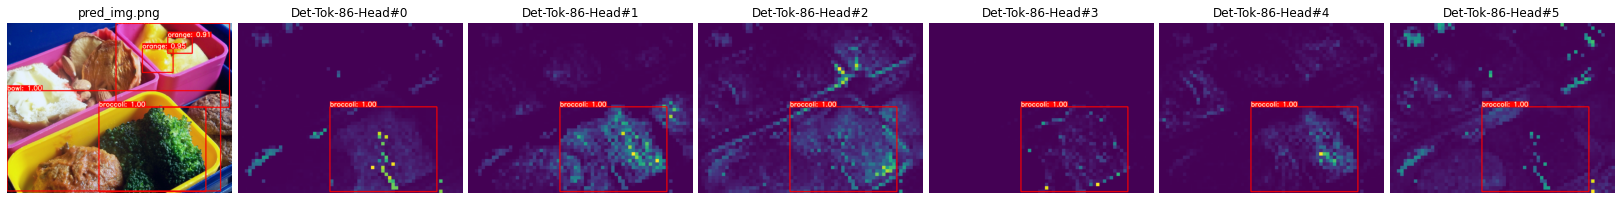

In [18]:
for dettoken_dir in det_tok_dirs:
    fig = plt.figure(constrained_layout=True, figsize=(32 * 0.7, 5 * 0.7), facecolor='white')
    gs = fig.add_gridspec(1, 7)
    axs_0 = [
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[0, 3]),
        fig.add_subplot(gs[0, 4]),
        fig.add_subplot(gs[0, 5]),
        fig.add_subplot(gs[0, 6]),
    ]
    dettoken_heads = ['attn-head0.png', 'attn-head1.png', 'attn-head2.png',
                      'attn-head3.png', 'attn-head4.png', 'attn-head5.png']
    dettoken_dir_files_0 = []
    for dettoken_head in dettoken_heads:
        dettoken_dir_files_0.append(os.path.join(dettoken_dir, dettoken_head))
    head_index=0
    for dettoken_dir_file, head_ax in zip(dettoken_dir_files_0, axs_0):
        im = Image.open(dettoken_dir_file)
        head_ax.imshow(im)
        head_ax.set_title('%s-Head#%d' %(dettoken_dir.split('/')[-1], head_index))
        head_ax.axis('off')
        head_index = head_index+1
    fleft_ax = fig.add_subplot(gs[0, 0])
    im = Image.open(os.path.join(OUTPUT_DIR, 'pred_img.png'))
    fleft_ax.imshow(im)
    fleft_ax.axis('off')
    fleft_ax.set_title('pred_img.png')